# 1. 폴더 정리

* 제공해드린 animals10.zip의 압축을 풀어 그 내용을 살펴보시고, 폴더 구조를 학습에 알맞도록 재구성해주세요
* 특히 각 클래스마다 약 30% 정도의 이미지를 test 폴더에 할당해주세요
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요 (ex. flat_test[:5]로 앞의 다섯값 확인)
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

In [1]:
### Guideline for convenience ###
# 압축 풀기
import os 

path_db = 'tire/tire-dataset'

In [2]:
class_names = os.listdir(path_db)[:3]
class_names

['flat.class', 'full.class', 'no-tire.class']

In [3]:
# 각 클래스별 파일 개수 확인 -> 변수로 해당 개수 저장
# Tip) 클래스가 10개이므로 각 클래스마다 똑같은 내용의 코드를 계속 써야할까요? 클래스 이름을 리스트로 저장해 for문을 돌리면서 코드를 재사용하는건 어떨까요?

In [4]:
from collections import defaultdict

In [5]:
class_info = defaultdict(dict)

for class_name in class_names:
    class_info[class_name]['len'] = len(os.listdir(f'{path_db}/{class_name}'))

In [6]:
from pprint import pprint

pprint(class_info)

defaultdict(<class 'dict'>,
            {'flat.class': {'len': 300},
             'full.class': {'len': 300},
             'no-tire.class': {'len': 300}})


In [7]:
# test에 넣을 이미지 개수 계산

for class_name in class_names:    
    class_info[class_name]['test_size'] = int(class_info[class_name]['len']*0.3)

In [8]:
pprint(class_info)

defaultdict(<class 'dict'>,
            {'flat.class': {'len': 300, 'test_size': 90},
             'full.class': {'len': 300, 'test_size': 90},
             'no-tire.class': {'len': 300, 'test_size': 90}})


In [12]:
# train, test 폴더 경로 선언 & 만들기

def check_mkdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        print("mk")

path_train = f"{path_db}/train" 
path_test = f"{path_db}/test"
check_mkdir(path_train)
check_mkdir(path_test)

mk


In [13]:
import shutil

In [14]:
for class_name in class_names:
    check_mkdir(f"{path_db}/train/{class_name}")
    check_mkdir(f"{path_db}/test/{class_name}")

mk
mk
mk
mk
mk


In [15]:
# train, test 폴더로 이미지 split해서 알맞게 집어넣기

import numpy as np

for class_name in class_names:    
    class_sp = class_info[class_name]
    test_idx = np.random.choice(list(range(class_sp['len'])), class_sp['test_size'], replace=False)
    train_idx = [i for i in range(class_sp['len']) if i not in test_idx]
    
    instance_names = np.array(os.listdir(f"{path_db}/{class_name}"))
    
    for k in instance_names[train_idx]:
        shutil.copy(f"{path_db}/{class_name}/{k}", f"{path_db}/train/{class_name}")
    for k in instance_names[test_idx]:
        shutil.copy(f"{path_db}/{class_name}/{k}", f"{path_db}/test/{class_name}")
pprint(class_info)

defaultdict(<class 'dict'>,
            {'flat.class': {'len': 300, 'test_size': 90},
             'full.class': {'len': 300, 'test_size': 90},
             'no-tire.class': {'len': 300, 'test_size': 90}})


# 2. CNN 모델
수업 코드에 '모델 성능에 대한 고민!!' 부분을 참고해서 **test 이미지 기준 최소 80% 이상**의 모델이 나올 수 있도록 학습을 진행해주세요.
* 중간중간 헷갈리다면 이것저것 확인하는 코드를 거쳐보세요
* 90% 이상의 모델이 이상적이긴 합니다
* 궁금한 점이 있을 경우, 슬랙 질문 채널 활용을 적극 권장합니다.

전반적으로 수업 코드와 비슷하게 짜면 되는데, 생각해봐야 할 것은
* 모든 이미지를 내가 정의하는 하나의 모델에 넣어야함
* 그말은 input 데이터의 차원이 항상 동일해야 된다는 말
* 그런데 과연 내가 가지고 있는 이미지들의 사이즈가 모두 같을까? - 대략 얼마정도 사이즈 가지고 있는지 코드로 확인해보면 더 좋음 (shape 확인)
* 이미지 사이즈를 통일시키기 위해서는 어떻게 해야할까? - transforms의 Resize, RandomCrop 써볼까?
* 동물 이미지에 적합한 Augmentation은 무엇이 있을까?

In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [29]:
# train, test 이미지를 위한 transforms function 정의
# 위에서 말한 포인트들 생각해보기 - 차원에 유의하자!
trans_tr = transforms.Compose([
    transforms.Resize(300),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [30]:
trans_te = transforms.Compose([
    transforms.Resize(300),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [31]:
# ImageFolder와 앞서 정의한 transforms function을 활용해 Dataset 객체 (train, test에 대해) 선언
train_data = torchvision.datasets.ImageFolder(
    root = f"{path_db}/train", # 바로 train 폴더 지정
    transform = trans_tr # transform은 그냥 편의상 cifar에서 썼던거 그대로
)
test_data = torchvision.datasets.ImageFolder(
    root = f"{path_db}/test",
    transform = trans_te
)

In [33]:
# train, test에 대해 DataLoader 정의
loader_tr = torch.utils.data.DataLoader(
    train_data,
    batch_size = 32,      # 일반적으로 batch size = 16, 32
    shuffle=True,         # train dataloader는 epoch마다 데이터 다시 섞어서 batch 만들고 학습! - 학습 효율 up
    num_workers=2
)

loader_te = torch.utils.data.DataLoader(
    test_data,
    batch_size = 32,      # 일반적으로 batch size = 16, 32
    shuffle=False,        # test dataloader는 데이터 매번 섞을 이유가 없음 - 어차피 확인 용도
    num_workers=2
)

In [78]:
### Model 클래스 정의 - 차원에 유의하자!
# 10개의 클래스를 분류해야 하는 꽤나 복잡한 task - 모델 구조를 어느 정도로 복잡하게 짜볼까?
# 가장 마지막 Linear의 out_features는 얼마로 해야할까?
#### 모델 정의 시 유념해야할 건 각 층의 결과물의 차원!
#### 모델이 복잡해지면 복잡해질수록 이는 더욱 중요해지므로 레이어별로 도출되는 데이터의 크기를 써넣는 것을 추천 (안맞으면 에러남)
# (해당 모델은 임의로 만든 모델로 성능을 보장하지 X)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        ##### Layer 정의 #####
        self.layer = nn.Sequential(
            # 맨처음 RGB 채널 3개이므로 가장 처음 in_channels = 3
            # img의 가장 첫 차원이 batch_size 값은 계속해서 유지
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5),             # [batch_size,3,32,32] -> [batch_size,16,28,28] -> same with? - using 16 filters
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),            # [batch_size,16,28,28] -> [batch_size,32,24,24]
            nn.ReLU(),
            nn.Dropout(0.2), # 0.2 확률로 Dropout
            nn.MaxPool2d(kernel_size=2, stride=2),                                # [batch_size,32,24,24] -> [batch_size,32,12,12]
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2), # [batch_size,32,12,12] -> [batch_size,32,12,12] -> padding*2 주의!
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),            # [batch_size,32,12,12] -> [batch_size,32,10,10]
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)                                 # [batch_size,32,10,10] -> [batch_size,32,5,5]
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(32*72*72,100),                                                # [batch_size,32*5*5] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,10)
        )

    def forward(self, x):
        # forward pass 과정
        out = self.layer(x)
        out = out.view(out.size(0),-1)  # FC layer에 들어가기전, flatten! - view 함수 활용
                                        # 가장 첫 차원인 batch_size는 유지하고 나머지 차원들을 하나로 합치기 - [batch_size,16,5,5] -> [batch_size,16*5*5]
        out = self.fc_layer(out)
        return out

In [79]:
# torchsummary로 모델 차원 어떻게 나오는지 돌려보기
from torchsummary import summary
model = MyModel().cuda() # 모델 객체 선언
summary(model, (3,300,300), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 296, 296]           1,216
              ReLU-2         [32, 16, 296, 296]               0
            Conv2d-3         [32, 32, 292, 292]          12,832
              ReLU-4         [32, 32, 292, 292]               0
           Dropout-5         [32, 32, 292, 292]               0
         MaxPool2d-6         [32, 32, 146, 146]               0
            Conv2d-7         [32, 32, 146, 146]          25,632
              ReLU-8         [32, 32, 146, 146]               0
            Conv2d-9         [32, 32, 144, 144]           9,248
             ReLU-10         [32, 32, 144, 144]               0
          Dropout-11         [32, 32, 144, 144]               0
        MaxPool2d-12           [32, 32, 72, 72]               0
           Linear-13                  [32, 100]      16,588,900
             ReLU-14                  [

In [80]:
device = 'cuda'

In [81]:
# loss func, optimizer 정의
criterion = nn.CrossEntropyLoss().cuda() # criterion (loss func)도 device 위에서
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001) # 보통 Adam의 learning rate로 0.001 사용
                                                                                  # weight_decay = L2 Regularization의 lambda값 (가중치 제한 정도)

In [82]:
with torch.no_grad():
    for i, (inputs, targets) in enumerate(loader_tr):
        inputs, targets = inputs.cuda(), targets.cuda()
        print(inputs.shape)  # batch_size개의 이미지
        print(targets.shape) # batch_size개의 클래스

        outputs = model(inputs)
        print(outputs.shape) # outputs는 32, 10 차원 (32개 data의 확률 10개씩)
        print(targets.shape) # targets는 32차원 (32개 data의 실제 클래스)

        loss = criterion(outputs, targets)  # -> cross entropy 식에 넣을때 이런 형태로 넣으면됨 (outputs, targets의 차원을 맞출 필요가 없음)
        print(loss.item())

        print(outputs.max(1)[1]) # 예측한 클래스
        print(targets) # 실제 클래스
        correct = (outputs.max(1)[1] == targets).sum().item() # 맞게 예측한 클래스 개수
        print(correct)
        break

torch.Size([32, 3, 300, 300])
torch.Size([32])
torch.Size([32, 10])
torch.Size([32])
2.305614948272705
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 0, 6, 6, 6, 6, 6], device='cuda:0')
tensor([2, 0, 1, 2, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 1, 0, 2, 2, 1, 2, 1, 0, 2, 1,
        1, 1, 1, 1, 0, 1, 2, 2], device='cuda:0')
0


In [87]:
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [88]:
# train 함수 정의
def train(epoch, loader):
    print(f'\n[ Train epoch: {epoch+1} ]')

    model.train() # train은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하고 진행하기 위함

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어줘야됨
        
        # DL 학습 기본 코드
        optimizer.zero_grad() # gradient 초기화
        outputs = model(inputs) # 현재 batch의 inputs을 모델에 넣어 outputs 추출 (확률값)
        loss = criterion(outputs, targets) # 추출한 outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        optimizer.step() # weight parameter update

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 300 == 299:
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 300 batches: {running_loss / 300}') # 이렇게 출력하는 것이 꼭 필요한 것은 아니지만, 중간중간 확인을 위해 매우 권장
            running_loss = 0.0

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    seq_train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [89]:
# test 함수 정의
def test(epoch, loader):
    print(f'\n[ Test epoch: {epoch+1} ]')

    model.eval() # eval은 항상 이걸 지정하고 시작! - Dropout, Batch Normalization 등의 효과를 적용하지 않기 위함!
                   # ex. evaluation 할때는 Dropout 없이 지금까지 학습한 모든 node를 활용해서 진행해야됨

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    seq_test_acc.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

In [93]:
for epoch in range(0, num_epoch):
    train(epoch, loader_tr)
    test(epoch, loader_te)

# model 저장! - parameter값 저장
torch.save(model.state_dict(), './model.pt')
print('Model Saved!')


[ Train epoch: 1 ]

Total train accuarcy: 97.77777777777777
Total train loss: 0.06433671666309237

[ Test epoch: 1 ]

Test accuarcy: 97.77777777777777
Test average loss: 0.06125032565452986

[ Train epoch: 2 ]

Total train accuarcy: 98.0952380952381
Total train loss: 0.06084524893667549

[ Test epoch: 2 ]

Test accuarcy: 98.88888888888889
Test average loss: 0.04397206303353111

[ Train epoch: 3 ]

Total train accuarcy: 96.34920634920636
Total train loss: 0.09408117306884378

[ Test epoch: 3 ]

Test accuarcy: 98.51851851851852
Test average loss: 0.04468852586837278

[ Train epoch: 4 ]

Total train accuarcy: 97.3015873015873
Total train loss: 0.061917351675219834

[ Test epoch: 4 ]

Test accuarcy: 98.14814814814815
Test average loss: 0.05630693394212156

[ Train epoch: 5 ]

Total train accuarcy: 97.93650793650794
Total train loss: 0.052498600957915184

[ Test epoch: 5 ]

Test accuarcy: 98.51851851851852
Test average loss: 0.053638755780411884
Model Saved!


In [86]:
# loss, accuracy 추이 확인 with plt.plot

In [94]:
import matplotlib.pyplot as plt

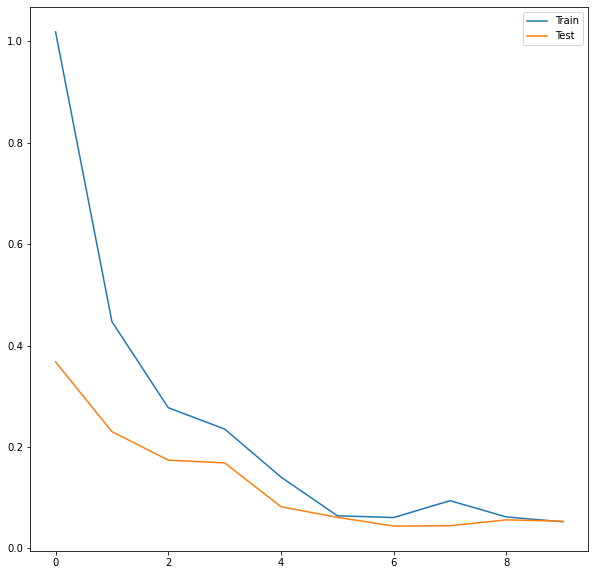

In [95]:
plt.figure(figsize=(10,10))
plt.plot(seq_train_loss, label='Train')
plt.plot(seq_test_loss, label='Test')
plt.legend()
plt.show()

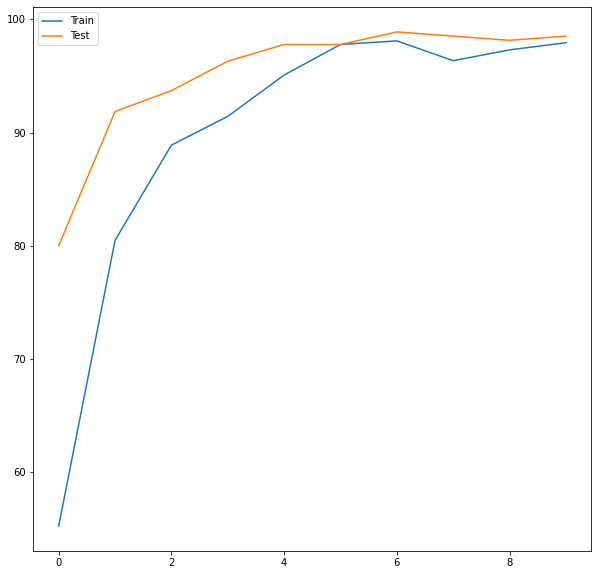

In [96]:
plt.figure(figsize=(10,10))
plt.plot(seq_train_acc, label='Train')
plt.plot(seq_test_acc, label='Test')
plt.legend()
plt.show()